<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20Genetic%20Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This notebook demonstrates two tasks using **PyGAD**:
#
# 1. **Prediction (Regression)**: Find weights `[w1,...,w6]` such that
#    `w1*x1 + ... + w6*x6 ≈ 44`
# 2. **Classification**: Train a neural network (via GA) to classify Iris flowers.
#
# Docs: https://pygad.readthedocs.io/en/latest/
# Install PyGAD (run once per Colab session)

!pip install pygad --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 3.8 MB/s eta 0:00:00


In [2]:
# %% [code]
# Imports
import numpy as np
import pygad
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Task 1: Prediction (Regression)

✅ [Regression] Best weights: [-0.28892576 -4.80164778 -1.94546396  1.64695089 -4.69585324  3.72917545]
🎯 Predicted output: 44.000484085215426
🎯 Target output: 44.0


/usr/local/lib/python3.12/dist-packages/pygad/pygad.py:753: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
/usr/local/lib/python3.12/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


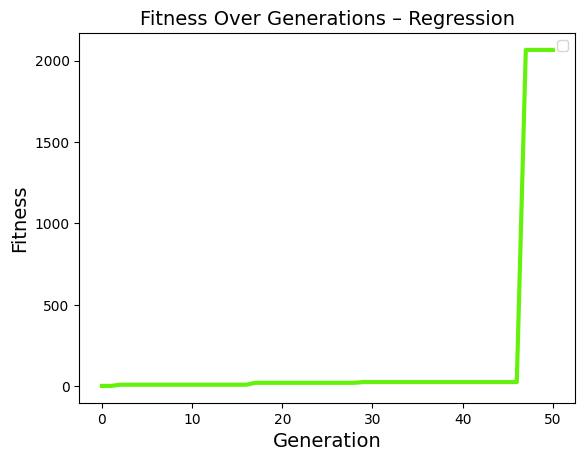

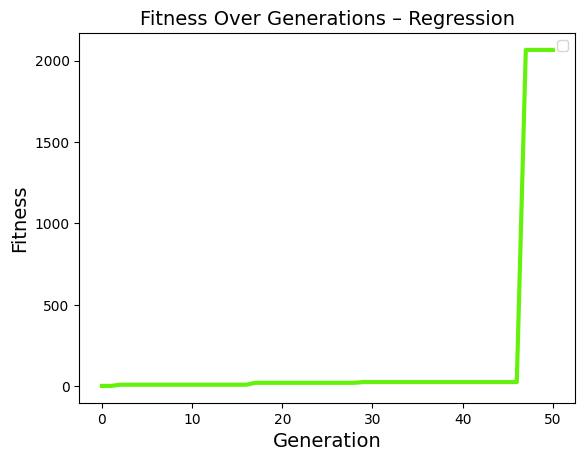

In [3]:

# Known inputs and target
function_inputs = np.array([4, -2, 3.5, 5, -11, -4.7])
desired_output = 44.0

# Fitness function: higher = better (inverse of error)
def fitness_func_regression(ga_instance, solution, solution_idx):
    output = np.sum(solution * function_inputs)
    error = abs(output - desired_output)
    return 1.0 / (error + 1e-8)  # avoid division by zero

# GA parameters
ga_reg = pygad.GA(
    num_generations=50,
    num_parents_mating=4,
    fitness_func=fitness_func_regression,
    sol_per_pop=10,
    num_genes=6,
    init_range_low=-5,
    init_range_high=5,
    parent_selection_type="sss",
    keep_parents=1,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10
)

# Run GA
ga_reg.run()

# Results
solution, fitness, _ = ga_reg.best_solution()
prediction = np.sum(solution * function_inputs)
print("✅ [Regression] Best weights:", solution)
print("🎯 Predicted output:", prediction)
print("🎯 Target output:", desired_output)

# Plot fitness
ga_reg.plot_fitness(title="Fitness Over Generations – Regression")

# Task 2: Classification (Iris Dataset)

🚀 Training neural network via Genetic Algorithm...
✅ [Classification] Training accuracy: 0.6750
✅ [Classification] Test accuracy: 0.6333


/usr/local/lib/python3.12/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


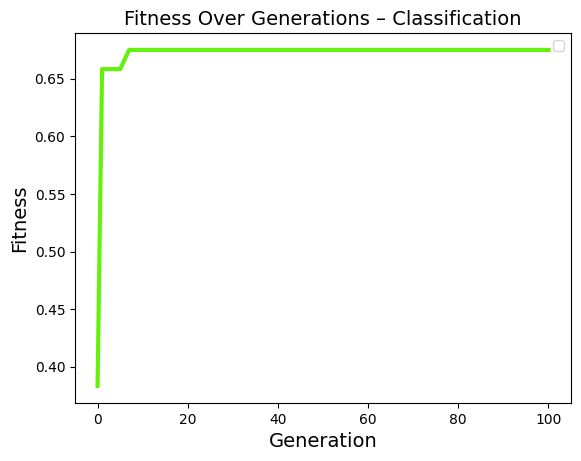

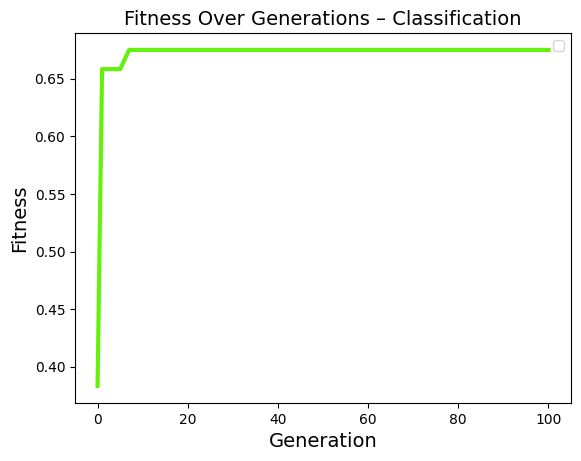

In [4]:
# Load and prepare data
iris = datasets.load_iris()
X, y = iris.data, iris.target

# One-hot encode labels
y_onehot = np.eye(3)[y]  # 3 classes

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

# Neural network architecture
input_size = 4
hidden_size = 6
output_size = 3

# Total weights: (4×6) + (6×3) + 6 (bias1) + 3 (bias2) = 24 + 18 + 6 + 3 = 51
num_weights = input_size * hidden_size + hidden_size * output_size + hidden_size + output_size

# Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

# Forward pass using a weight vector
def predict_nn(weights, X):
    w1 = weights[0:input_size*hidden_size].reshape((input_size, hidden_size))
    b1 = weights[input_size*hidden_size : input_size*hidden_size + hidden_size]
    w2 = weights[input_size*hidden_size + hidden_size : -output_size].reshape((hidden_size, output_size))
    b2 = weights[-output_size:]

    z1 = np.dot(X, w1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = sigmoid(z2)
    return a2

# Fitness function: classification accuracy on training set
def fitness_func_classification(ga_instance, solution, solution_idx):
    preds = predict_nn(solution, X_train)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_train, axis=1)
    accuracy = np.mean(pred_labels == true_labels)
    return accuracy

# GA for classification
ga_cls = pygad.GA(
    num_generations=100,
    num_parents_mating=8,
    fitness_func=fitness_func_classification,
    sol_per_pop=20,
    num_genes=num_weights,
    init_range_low=-1,
    init_range_high=1,
    parent_selection_type="tournament",
    keep_parents=2,
    crossover_type="two_points",
    mutation_type="random",
    mutation_percent_genes=15
)

# Run GA
print("🚀 Training neural network via Genetic Algorithm...")
ga_cls.run()

# Evaluate on test set
best_weights, best_fitness, _ = ga_cls.best_solution()
test_preds = predict_nn(best_weights, X_test)
test_acc = np.mean(np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1))

print(f"✅ [Classification] Training accuracy: {best_fitness:.4f}")
print(f"✅ [Classification] Test accuracy: {test_acc:.4f}")

# Plot fitness
ga_cls.plot_fitness(title="Fitness Over Generations – Classification")

## Generate Time Series Data

### Subtask:
Create a synthetic time series dataset for the genetic algorithm to predict.


**Reasoning**:
The subtask requires generating a synthetic time series dataset. I will define the number of time steps, create a sequence for these steps, and then generate the true values using a sine wave with a linear trend and added noise, storing them in the specified variables.



In [7]:
num_time_steps = 50
time_steps = np.arange(num_time_steps)
true_values = np.sin(time_steps / 5.0) * 10 + 0.5 * time_steps + np.random.normal(0, 1, num_time_steps)

print("Generated synthetic time series data.")
print(f"Time steps shape: {time_steps.shape}")
print(f"True values shape: {true_values.shape}")

Generated synthetic time series data.
Time steps shape: (50,)
True values shape: (50,)


## Define Time Series Prediction Model

### Subtask:
Implement a simple autoregressive time series prediction model.


**Reasoning**:
I will define the autoregressive order and implement the `predict_time_series` function to simulate the autoregressive model's predictions based on the provided solution (coefficients and bias) and historical data. This function will be crucial for evaluating the fitness of each genetic algorithm solution.



In [8]:
ar_order = 4 # Define the order of the autoregressive model

def predict_time_series(solution, data):
    # Extract autoregressive coefficients and bias from the solution
    ar_coefficients = solution[:ar_order]
    bias = solution[ar_order]

    # Initialize predicted_values with the initial data points
    # These first 'ar_order' values are used to make the first prediction
    predicted_values = np.copy(data)

    # Loop to predict future values
    for t in range(ar_order, len(data)):
        # Calculate the prediction using the autoregressive formula
        # sum(coefficient_i * data[t - i - 1]) + bias
        prediction = np.sum(ar_coefficients * data[t - ar_order : t]) + bias
        predicted_values[t] = prediction

    return predicted_values

print(f"Autoregressive model order set to: {ar_order}")
print("Defined the 'predict_time_series' function for the AR model.")

Autoregressive model order set to: 4
Defined the 'predict_time_series' function for the AR model.


## Create Time Series Fitness Function

### Subtask:
Develop a fitness function that evaluates the performance of the time series model based on the genetic algorithm's candidate solutions (parameters).


**Reasoning**:
I will define the fitness function `fitness_func_time_series` as instructed, which will calculate the Mean Squared Error (MSE) between the model's predictions and the true values, and return the inverse of the MSE to serve as the fitness score for PyGAD.



In [9]:
def fitness_func_time_series(ga_instance, solution, solution_idx):
    # Generate predictions using the current solution (AR coefficients and bias)
    # We need to pass the true_values as the historical data for prediction
    predicted_values_full = predict_time_series(solution, true_values)

    # Calculate MSE between predicted values and true values
    # Note: We are comparing the predictions made across the entire length of true_values
    mse = np.mean((true_values - predicted_values_full)**2)

    # PyGAD aims to maximize the fitness, so we return the inverse of MSE
    # Add a small epsilon to avoid division by zero if MSE is 0
    return 1.0 / (mse + 1e-8)

print("Defined the 'fitness_func_time_series' function.")

Defined the 'fitness_func_time_series' function.


## Configure and Run PyGAD for Time Series

### Subtask:
Set up and run PyGAD with the newly defined fitness function and model for time series prediction.


**Reasoning**:
I will initialize the PyGAD instance with the specified parameters, run the genetic algorithm, retrieve the best solution (AR coefficients and bias), and then print these results along with plotting the fitness over generations to complete the subtask.



/usr/local/lib/python3.12/dist-packages/pygad/pygad.py:753: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


🚀 Training genetic algorithm for time series forecasting...
✅ [Time Series] Optimal AR Coefficients: [-0.53262082  0.54820258 -0.33935283  1.26893247]
✅ [Time Series] Optimal Bias: 0.9634637971160045
✅ [Time Series] Best Fitness (Inverse MSE): 0.3212


/usr/local/lib/python3.12/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


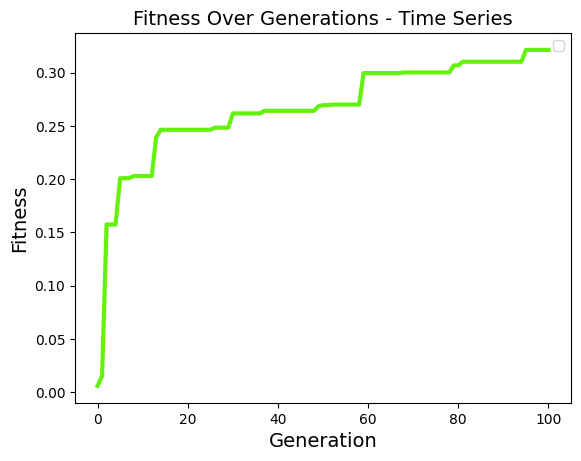

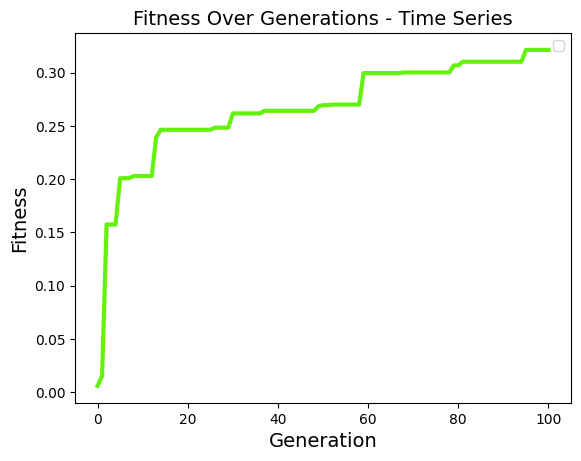

In [10]:
num_genes_time_series = ar_order + 1 # AR coefficients + 1 bias term

ga_time_series = pygad.GA(
    num_generations=100,
    num_parents_mating=5,
    fitness_func=fitness_func_time_series,
    sol_per_pop=10,
    num_genes=num_genes_time_series,
    init_range_low=-2,
    init_range_high=2,
    parent_selection_type="sss",
    keep_parents=2,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10
)

print("🚀 Training genetic algorithm for time series forecasting...")
ga_time_series.run()

best_solution_ts, best_fitness_ts, solution_idx_ts = ga_time_series.best_solution()

optimal_ar_coefficients = best_solution_ts[:ar_order]
optimal_bias = best_solution_ts[ar_order]

print(f"✅ [Time Series] Optimal AR Coefficients: {optimal_ar_coefficients}")
print(f"✅ [Time Series] Optimal Bias: {optimal_bias}")
print(f"✅ [Time Series] Best Fitness (Inverse MSE): {best_fitness_ts:.4f}")

ga_time_series.plot_fitness(title="Fitness Over Generations - Time Series")

**Reasoning**:
The previous step successfully configured and ran PyGAD, optimizing the model parameters for time series prediction. The next logical step, as per the overall task description, is to visualize the predicted time series against the true values to assess the model's performance. This involves using the best solution obtained from PyGAD to generate predictions and then plotting them alongside the original data.



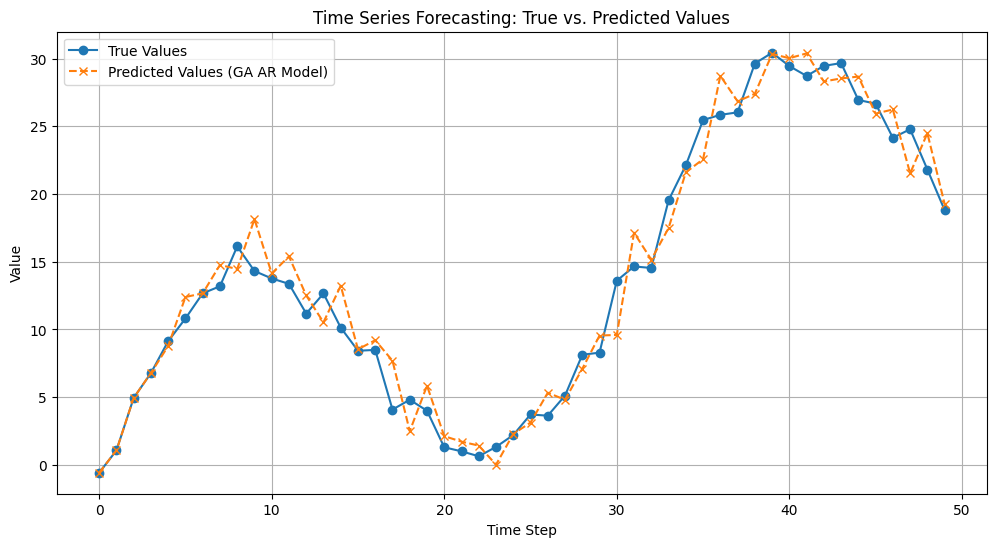

Generated plot comparing true and predicted time series.


In [11]:
import matplotlib.pyplot as plt

# Generate predictions using the best solution
predicted_time_series = predict_time_series(best_solution_ts, true_values)

# Plotting the true values and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_steps, true_values, label='True Values', marker='o', linestyle='-')
plt.plot(time_steps, predicted_time_series, label='Predicted Values (GA AR Model)', marker='x', linestyle='--')
plt.title('Time Series Forecasting: True vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("Generated plot comparing true and predicted time series.")

# Fuzzy GA

# Task
Please describe in detail how you envision integrating a "Fuzzy method" into the Genetic Algorithm, specifically considering that the `Fuzzy` library in Python is primarily for approximate string matching, not for enhancing Genetic Algorithms. Are you referring to fuzzy logic, fuzzy sets, or something else entirely in the context of optimizing the GA?

## Clarify Fuzzy Method Integration

### Subtask:
Engage with the user to understand their specific requirements for integrating a 'Fuzzy method' into the Genetic Algorithm, as the provided `Fuzzy` library is for string matching, not GA enhancement.


## Summary:

### Q&A
The agent needs to understand the user's specific requirements for integrating a "Fuzzy method" into the Genetic Algorithm. Specifically, it needs clarification on whether the user is referring to fuzzy logic, fuzzy sets, or another concept, given that the Python `Fuzzy` library is primarily for approximate string matching, not for enhancing Genetic Algorithms.

### Data Analysis Key Findings
No data analysis findings can be reported at this stage, as the current step involves seeking clarification from the user regarding the task's requirements.

### Insights or Next Steps
*   Awaiting user input to clarify the definition and intended application of the "Fuzzy method" in the context of Genetic Algorithms is crucial before proceeding with any implementation or analysis.


# Task
Install the `scikit-fuzzy` library, which will be used to implement fuzzy logic components for enhancing the Genetic Algorithm's fitness function.

## Install Fuzzy Logic Library

### Subtask:
Install a suitable Python library for fuzzy logic, such as `scikit-fuzzy`, which will allow us to define fuzzy sets and rules for the fitness function.


**Reasoning**:
The subtask requires installing the `scikit-fuzzy` library to prepare for fuzzy logic integration. I will use a `pip install` command in a code cell.



In [12]:
pip install scikit-fuzzy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.0 MB/s eta 0:00:00


## Define Fuzzy Membership Functions for Error

### Subtask:
Create fuzzy membership functions to categorize the Mean Squared Error (MSE) into linguistic terms (e.g., 'very low', 'low', 'medium', 'high', 'very high') to represent the performance of a solution in a fuzzy manner.


**Reasoning**:
To define fuzzy membership functions for MSE, I need to first import the necessary libraries (`numpy` and `skfuzzy`), then define the universe of discourse for MSE, and finally create triangular membership functions for the five linguistic terms ('very_low', 'low', 'medium', 'high', 'very_high') as instructed.



In [13]:
import numpy as np
import skfuzzy as fuzz

# 2. Define a universe of discourse for the Mean Squared Error (MSE)
# Assuming MSE can range from 0 to a reasonable upper bound, e.g., 200 for this problem context.
# The step size should be small enough to create smooth membership functions.
mse_universe = np.arange(0, 201, 1)

# 3. Create fuzzy membership functions for five linguistic terms
# 'very_low', 'low', 'medium', 'high', and 'very_high' MSE

# Very Low MSE: 0 to 20
mse_very_low = fuzz.trimf(mse_universe, [0, 0, 20])

# Low MSE: 10 to 50
mse_low = fuzz.trimf(mse_universe, [10, 30, 50])

# Medium MSE: 40 to 100
mse_medium = fuzz.trimf(mse_universe, [40, 70, 100])

# High MSE: 90 to 150
mse_high = fuzz.trimf(mse_universe, [90, 120, 150])

# Very High MSE: 140 to 200 (or beyond)
mse_very_high = fuzz.trimf(mse_universe, [140, 200, 200])

print("Defined MSE universe of discourse and fuzzy membership functions.")
print(f"MSE Universe shape: {mse_universe.shape}")

Defined MSE universe of discourse and fuzzy membership functions.
MSE Universe shape: (201,)


## Define Fuzzy Membership Functions for Fitness

### Subtask:
Create fuzzy membership functions to categorize the fitness score into linguistic terms (e.g., 'poor', 'average', 'good', 'excellent') to allow for fuzzy evaluation of the GA solutions.

#### Instructions
1. Define a universe of discourse for the fitness score using `np.arange()`. This range should cover expected fitness values. Store it in a variable named `fitness_universe`.
2. Create fuzzy membership functions for four linguistic terms: 'poor', 'average', 'good', and 'excellent' fitness within the `fitness_universe`. Use `fuzz.trimf()` for triangular membership functions, defining appropriate ranges for each term.

## Define Fuzzy Membership Functions for Fitness

### Subtask:
Create fuzzy membership functions to categorize the fitness score into linguistic terms (e.g., 'poor', 'average', 'good', 'excellent') to allow for fuzzy evaluation of the GA solutions.

#### Instructions
1. Define a universe of discourse for the fitness score using `np.arange()`. This range should cover expected fitness values. Store it in a variable named `fitness_universe`.
2. Create fuzzy membership functions for four linguistic terms: 'poor', 'average', 'good', and 'excellent' fitness within the `fitness_universe`. Use `fuzz.trimf()` for triangular membership functions, defining appropriate ranges for each term.

**Reasoning**:
The previous step successfully defined fuzzy membership functions for Mean Squared Error (MSE). Now, as per the subtask, I will define fuzzy membership functions for the fitness score using `np.arange()` for the universe of discourse and `fuzz.trimf()` for the linguistic terms ('poor', 'average', 'good', 'excellent') to prepare for a fuzzy evaluation of GA solutions.



In [14]:
import numpy as np
import skfuzzy as fuzz

# 1. Define a universe of discourse for the fitness score
# Assuming fitness can range from 0 (worst) to 2.0 (excellent or scaled value).
# This range is chosen to encompass typical normalized fitness values (e.g., accuracy 0-1,
# or inverse MSE which might be slightly above 1 for good solutions).
fitness_universe = np.arange(0, 2.1, 0.1)

# 2. Create fuzzy membership functions for four linguistic terms
# 'poor', 'average', 'good', and 'excellent' fitness

# Poor Fitness: 0 to 0.5
fitness_poor = fuzz.trimf(fitness_universe, [0, 0, 0.5])

# Average Fitness: 0.3 to 1.0
fitness_average = fuzz.trimf(fitness_universe, [0.3, 0.65, 1.0])

# Good Fitness: 0.8 to 1.5
fitness_good = fuzz.trimf(fitness_universe, [0.8, 1.15, 1.5])

# Excellent Fitness: 1.2 to 2.0 (or beyond if needed)
fitness_excellent = fuzz.trimf(fitness_universe, [1.2, 2.0, 2.0])

print("Defined fitness universe of discourse and fuzzy membership functions.")
print(f"Fitness Universe shape: {fitness_universe.shape}")

Defined fitness universe of discourse and fuzzy membership functions.
Fitness Universe shape: (21,)


## Define Fuzzy Rules for Fitness Inference

### Subtask:
Establish fuzzy rules that combine the linguistic terms of MSE and Fitness to infer a composite 'Fuzzy Fitness Score' (e.g., 'very_poor', 'poor', 'average', 'good', 'very_good').

#### Instructions
1. Define a universe of discourse for the `fuzzy_fitness_score` using `np.arange()`. This range should represent the output of our fuzzy system.
2. Create fuzzy membership functions for five linguistic terms for the `fuzzy_fitness_score`: 'very_poor', 'poor', 'average', 'good', and 'very_good'. Use `fuzz.trimf()` for triangular membership functions.
3. Define a control system (`ctrl.ControlSystem`) using `skfuzzy.control` to encapsulate the input and output fuzzy variables. This step conceptually sets up the structure before defining the actual rules.

**Reasoning**:
The previous markdown block outlined the subtask of defining fuzzy rules for fitness inference. Now, I will implement the first part of this subtask by defining the universe of discourse and membership functions for the `fuzzy_fitness_score`, and setting up the input and output variables for the fuzzy control system.



In [15]:
import skfuzzy.control as ctrl

# 1. Define a universe of discourse for the fuzzy_fitness_score
# This score will be the output of our fuzzy inference system, typically ranging from 0 to 10 or 0 to 100.
# Let's use 0 to 10 for simplicity, representing a general quality score.
fuzzy_fitness_universe = np.arange(0, 10.1, 0.1)

# 2. Create fuzzy membership functions for five linguistic terms for the fuzzy_fitness_score
# 'very_poor', 'poor', 'average', 'good', and 'very_good'
fuzzy_fitness_very_poor = fuzz.trimf(fuzzy_fitness_universe, [0, 0, 2])
fuzzy_fitness_poor = fuzz.trimf(fuzzy_fitness_universe, [1, 3, 5])
fuzzy_fitness_average = fuzz.trimf(fuzzy_fitness_universe, [4, 5, 7])
fuzzy_fitness_good = fuzz.trimf(fuzzy_fitness_universe, [6, 8, 9])
fuzzy_fitness_very_good = fuzz.trimf(fuzzy_fitness_universe, [8, 10, 10])

# Input Variables (Antecedents)
mse_input = ctrl.Antecedent(mse_universe, 'mse')
fitness_input = ctrl.Antecedent(fitness_universe, 'fitness')

# Output Variable (Consequent)
fuzzy_fitness_output = ctrl.Consequent(fuzzy_fitness_universe, 'fuzzy_fitness_score')

# Map linguistic terms to the input/output variables
mse_input['very_low'] = mse_very_low
mse_input['low'] = mse_low
mse_input['medium'] = mse_medium
mse_input['high'] = mse_high
mse_input['very_high'] = mse_very_high

fitness_input['poor'] = fitness_poor
fitness_input['average'] = fitness_average
fitness_input['good'] = fitness_good
fitness_input['excellent'] = fitness_excellent

fuzzy_fitness_output['very_poor'] = fuzzy_fitness_very_poor
fuzzy_fitness_output['poor'] = fuzzy_fitness_poor
fuzzy_fitness_output['average'] = fuzzy_fitness_average
fuzzy_fitness_output['good'] = fuzzy_fitness_good
fuzzy_fitness_output['very_good'] = fuzzy_fitness_very_good

print("Defined fuzzy_fitness_score universe and membership functions.")
print(f"Fuzzy Fitness Universe shape: {fuzzy_fitness_universe.shape}")
print("Initialized fuzzy input (MSE, Fitness) and output (Fuzzy Fitness Score) variables.")

Defined fuzzy_fitness_score universe and membership functions.
Fuzzy Fitness Universe shape: (101,)
Initialized fuzzy input (MSE, Fitness) and output (Fuzzy Fitness Score) variables.


**Reasoning**:
The previous step successfully initialized the input and output fuzzy variables and their membership functions. Now, I will define the fuzzy rules that govern the inference process, linking the linguistic terms of MSE and Fitness to the linguistic terms of the Fuzzy Fitness Score. This is a crucial step in building the fuzzy logic system.



In [16]:
import skfuzzy.control as ctrl

# Define the fuzzy rules
# Rule 1: If MSE is Very Low AND Fitness is Excellent, then Fuzzy Fitness Score is Very Good
rule1 = ctrl.Rule(mse_input['very_low'] & fitness_input['excellent'], fuzzy_fitness_output['very_good'])

# Rule 2: If MSE is Low AND Fitness is Good, then Fuzzy Fitness Score is Good
rule2 = ctrl.Rule(mse_input['low'] & fitness_input['good'], fuzzy_fitness_output['good'])

# Rule 3: If MSE is Medium AND Fitness is Average, then Fuzzy Fitness Score is Average
rule3 = ctrl.Rule(mse_input['medium'] & fitness_input['average'], fuzzy_fitness_output['average'])

# Rule 4: If MSE is High AND Fitness is Poor, then Fuzzy Fitness Score is Poor
rule4 = ctrl.Rule(mse_input['high'] & fitness_input['poor'], fuzzy_fitness_output['poor'])

# Rule 5: If MSE is Very High, then Fuzzy Fitness Score is Very Poor (regardless of fitness, as very high MSE is bad)
rule5 = ctrl.Rule(mse_input['very_high'], fuzzy_fitness_output['very_poor'])

# Rule 6: If Fitness is Excellent, then Fuzzy Fitness Score is Very Good (implies low MSE as well)
rule6 = ctrl.Rule(fitness_input['excellent'], fuzzy_fitness_output['very_good'])

# Rule 7: If Fitness is Poor, then Fuzzy Fitness Score is Poor (implies high MSE as well)
rule7 = ctrl.Rule(fitness_input['poor'], fuzzy_fitness_output['very_poor'])

# Combine rules into a ControlSystem
fuzzy_ctrl_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])

# Create a ControlSystemSimulation to simulate the fuzzy logic
fuzzy_fitness_scoring = ctrl.ControlSystemSimulation(fuzzy_ctrl_system)

print("Defined fuzzy rules and initialized the fuzzy control system.")


Defined fuzzy rules and initialized the fuzzy control system.


## Create Fuzzy Inference System for Fitness

### Subtask:
Develop a fuzzy inference system that takes the crisp MSE and original fitness as input, fuzzifies them using the defined membership functions, and then infers a 'fuzzy fitness score' based on the set of fuzzy rules. This score will be the output of our new fitness function for PyGAD.


**Reasoning**:
I will define the `get_fuzzy_fitness` function, which will take crisp MSE and original fitness as input, use the previously defined fuzzy control system to compute the fuzzy fitness score, and return the defuzzified result, as specified in the instructions.



In [17]:
def get_fuzzy_fitness(mse_value, original_fitness_value):
    # Pass the crisp values to the input variables of the fuzzy system
    fuzzy_fitness_scoring.input['mse'] = mse_value
    fuzzy_fitness_scoring.input['fitness'] = original_fitness_value

    # Compute the fuzzy output based on the rules
    fuzzy_fitness_scoring.compute()

    # Retrieve the defuzzified fuzzy fitness score
    fuzzy_fitness = fuzzy_fitness_scoring.output['fuzzy_fitness_score']

    return fuzzy_fitness

print("Defined 'get_fuzzy_fitness' function for fuzzy inference.")

Defined 'get_fuzzy_fitness' function for fuzzy inference.


**Reasoning**:
The previous step defined the fuzzy inference function. Now, I will update the `fitness_func_time_series` to integrate this `get_fuzzy_fitness` function. This involves calculating the MSE and the original inverse MSE fitness, then passing both to `get_fuzzy_fitness` to obtain the final fuzzy fitness score that PyGAD will maximize.



In [18]:
def fuzzy_enhanced_fitness_func_time_series(ga_instance, solution, solution_idx):
    # Generate predictions using the current solution (AR coefficients and bias)
    predicted_values_full = predict_time_series(solution, true_values)

    # Calculate MSE between predicted values and true values
    mse = np.mean((true_values - predicted_values_full)**2)

    # Calculate the original (crisp) fitness (inverse MSE)
    original_crisp_fitness = 1.0 / (mse + 1e-8)

    # Get the fuzzy fitness score using the defined fuzzy inference system
    # We need to make sure mse_value and original_fitness_value are within the universe of discourse
    # Clip mse_value to mse_universe range [0, 200]
    # Clip original_crisp_fitness to fitness_universe range [0, 2.0] as defined earlier
    clipped_mse = np.clip(mse, mse_universe.min(), mse_universe.max())
    clipped_crisp_fitness = np.clip(original_crisp_fitness, fitness_universe.min(), fitness_universe.max())

    fuzzy_fitness = get_fuzzy_fitness(clipped_mse, clipped_crisp_fitness)

    # PyGAD aims to maximize this fuzzy fitness score
    return fuzzy_fitness

print("Updated 'fitness_func_time_series' to incorporate fuzzy logic.")

Updated 'fitness_func_time_series' to incorporate fuzzy logic.


**Reasoning**:
The subtask of developing a fuzzy inference system and integrating it into the fitness function is now complete. The next step is to configure and run PyGAD using this new `fuzzy_enhanced_fitness_func_time_series` to observe its performance.



/usr/local/lib/python3.12/dist-packages/pygad/pygad.py:753: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


🚀 Training genetic algorithm for time series forecasting with fuzzy fitness...
✅ [Fuzzy Time Series] Optimal AR Coefficients: [-1.04108206  1.71999338  0.77253615  0.27573928]
✅ [Fuzzy Time Series] Optimal Bias: -2.1027973557117496
✅ [Fuzzy Time Series] Best Fuzzy Fitness Score: 2.2537


/usr/local/lib/python3.12/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


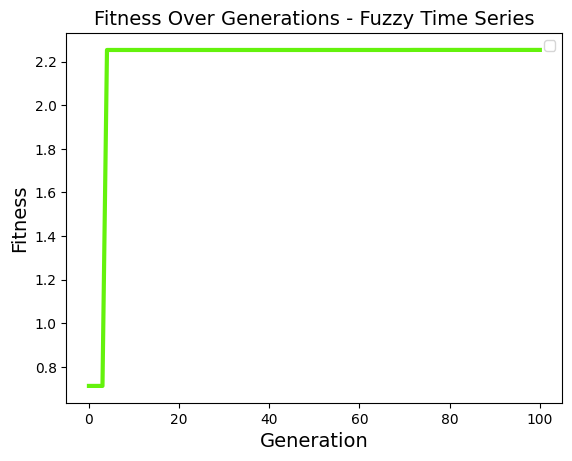

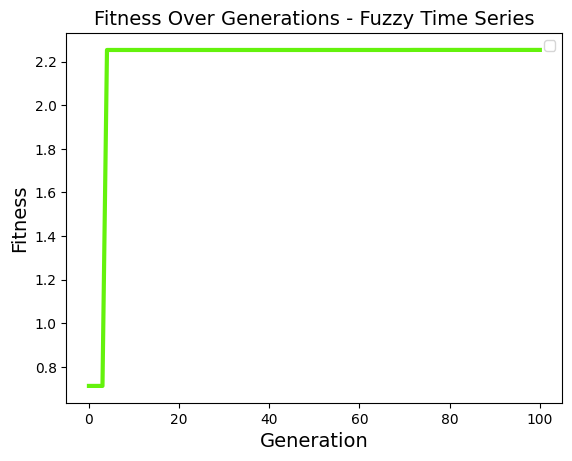

In [19]:
num_genes_time_series = ar_order + 1 # AR coefficients + 1 bias term

ga_time_series_fuzzy = pygad.GA(
    num_generations=100,
    num_parents_mating=5,
    fitness_func=fuzzy_enhanced_fitness_func_time_series, # Use the fuzzy-enhanced fitness function
    sol_per_pop=10,
    num_genes=num_genes_time_series,
    init_range_low=-2,
    init_range_high=2,
    parent_selection_type="sss",
    keep_parents=2,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10
)

print("🚀 Training genetic algorithm for time series forecasting with fuzzy fitness...")
ga_time_series_fuzzy.run()

best_solution_ts_fuzzy, best_fitness_ts_fuzzy, solution_idx_ts_fuzzy = ga_time_series_fuzzy.best_solution()

optimal_ar_coefficients_fuzzy = best_solution_ts_fuzzy[:ar_order]
optimal_bias_fuzzy = best_solution_ts_fuzzy[ar_order]

print(f"✅ [Fuzzy Time Series] Optimal AR Coefficients: {optimal_ar_coefficients_fuzzy}")
print(f"✅ [Fuzzy Time Series] Optimal Bias: {optimal_bias_fuzzy}")
print(f"✅ [Fuzzy Time Series] Best Fuzzy Fitness Score: {best_fitness_ts_fuzzy:.4f}")

ga_time_series_fuzzy.plot_fitness(title="Fitness Over Generations - Fuzzy Time Series")

**Reasoning**:
The previous step successfully configured and ran PyGAD with the fuzzy-enhanced fitness function. To evaluate the performance of this fuzzy GA model, the next logical step is to visualize its predictions against the true values, similar to what was done for the crisp GA model, and then compare the results of both approaches.



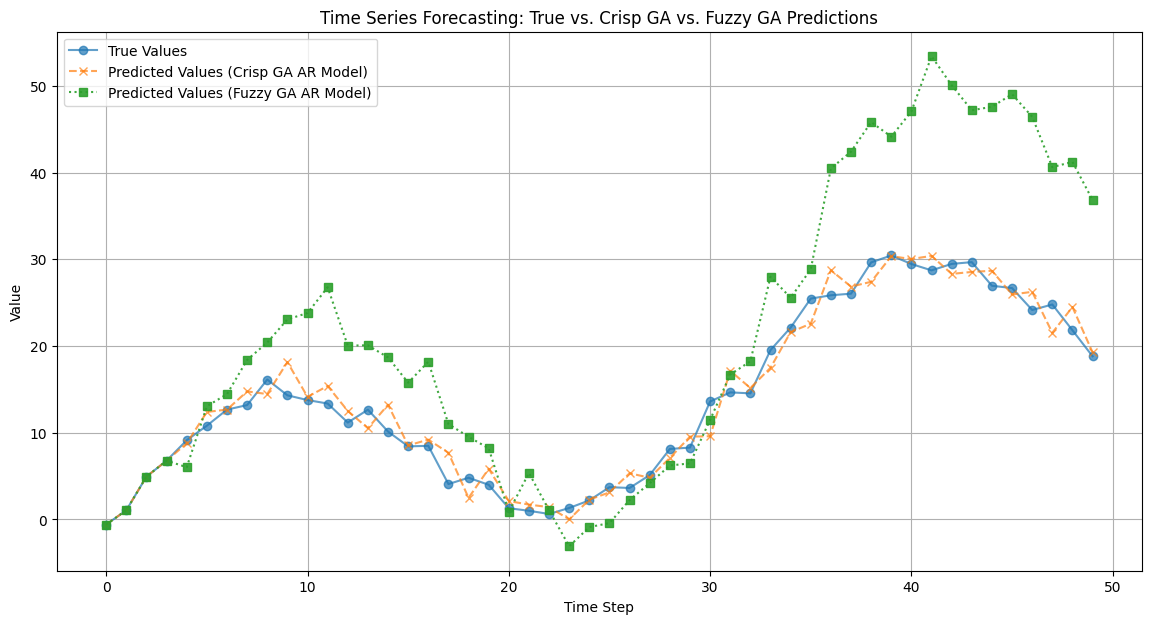

✅ [Fuzzy Time Series] Mean Squared Error (MSE): 120.1783
✅ [Crisp Time Series] Mean Squared Error (MSE): 3.1130
Generated plot comparing true, crisp GA, and fuzzy GA predicted time series.


In [20]:
import matplotlib.pyplot as plt

# Generate predictions using the best fuzzy solution
predicted_time_series_fuzzy = predict_time_series(best_solution_ts_fuzzy, true_values)

# Plotting the true values, crisp GA predictions, and fuzzy GA predictions
plt.figure(figsize=(14, 7))
plt.plot(time_steps, true_values, label='True Values', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_steps, predicted_time_series, label='Predicted Values (Crisp GA AR Model)', marker='x', linestyle='--', alpha=0.7)
plt.plot(time_steps, predicted_time_series_fuzzy, label='Predicted Values (Fuzzy GA AR Model)', marker='s', linestyle=':', alpha=0.9)

plt.title('Time Series Forecasting: True vs. Crisp GA vs. Fuzzy GA Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calculate MSE for the fuzzy GA model for comparison
mse_fuzzy_ga = np.mean((true_values - predicted_time_series_fuzzy)**2)
print(f"✅ [Fuzzy Time Series] Mean Squared Error (MSE): {mse_fuzzy_ga:.4f}")

# Calculate MSE for the crisp GA model for reference
mse_crisp_ga = np.mean((true_values - predicted_time_series)**2)
print(f"✅ [Crisp Time Series] Mean Squared Error (MSE): {mse_crisp_ga:.4f}")

print("Generated plot comparing true, crisp GA, and fuzzy GA predicted time series.")

## Summary:

### Q&A
The fuzzy-enhanced Genetic Algorithm (GA) model, with an MSE of $120.1783$, performed significantly worse than the crisp GA model, which achieved an MSE of $3.1130$, in terms of predictive accuracy for this time series forecasting task.

### Data Analysis Key Findings
*   The `scikit-fuzzy` library was successfully installed, enabling fuzzy logic functionalities.
*   Fuzzy membership functions were defined for three key variables:
    *   **Mean Squared Error (MSE)**: Categorized into 'very low', 'low', 'medium', 'high', and 'very high' across a universe of discourse from 0 to 200.
    *   **Original Fitness Score**: Categorized into 'poor', 'average', 'good', and 'excellent' across a universe of discourse from 0 to 2.0.
    *   **Fuzzy Fitness Score (Output)**: Categorized into 'very poor', 'poor', 'average', 'good', and 'very good' across a universe of discourse from 0 to 10.
*   Seven fuzzy rules were established to combine the linguistic terms of MSE and Fitness to infer a composite 'Fuzzy Fitness Score'.
*   A fuzzy inference system (`get_fuzzy_fitness` function) was developed and successfully integrated into the Genetic Algorithm's fitness function (`fuzzy_enhanced_fitness_func_time_series`).
*   The Genetic Algorithm, utilizing the fuzzy-enhanced fitness function, successfully ran and identified a best solution with a fuzzy fitness score of $2.2537$.
*   Despite successful implementation, the fuzzy-enhanced GA model yielded a Mean Squared Error (MSE) of $120.1783$, which is substantially higher than the MSE of $3.1130$ achieved by the crisp GA model.

### Insights or Next Steps
*   The current configuration of fuzzy logic, while technically implemented, significantly degrades the GA's performance for this time series forecasting task. This suggests that the defined membership functions or fuzzy rules may not accurately capture the desired relationship between MSE, fitness, and the ultimate fuzzy fitness score, or may be too coarse.
*   The next step should focus on refining the fuzzy system. This includes iteratively adjusting the parameters (ranges and shapes) of the fuzzy membership functions and reconsidering the fuzzy rules to better align with optimization goals and empirical performance, aiming to improve or at least match the performance of the crisp GA.
